# Connect Git with  Colab

In [1]:
# --- always get latest repo state in Colab ---
import os, sys, subprocess

REPO_URL  = "https://github.com/Wmeesena/Safe_Start.git"
REPO_ROOT = "/content/Safe_Start"     # repo root
WORKDIR   = os.path.join(REPO_ROOT, "MAGIC")
BRANCH    = "main"

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

if not os.path.isdir(REPO_ROOT):
    run(["git", "clone", "--depth", "1", "--branch", BRANCH, REPO_URL, REPO_ROOT])
else:
    run(["git", "-C", REPO_ROOT, "fetch", "origin"])
    run(["git", "-C", REPO_ROOT, "checkout", BRANCH])
    run(["git", "-C", REPO_ROOT, "reset", "--hard", f"origin/{BRANCH}"])


# Set working dir and import path
os.chdir(WORKDIR if os.path.isdir(WORKDIR) else REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())
!git -C {REPO_ROOT} rev-parse --abbrev-ref HEAD
!git -C {REPO_ROOT} rev-parse HEAD

# installs
%pip install -q ucimlrepo


$ git clone --depth 1 --branch main https://github.com/Wmeesena/Safe_Start.git /content/Safe_Start
CWD: /content/Safe_Start/MAGIC
main
33592c55996067d11e1ab40f44963006a0bbfe2e


# Setup

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import torch
from src.models.mlp import MLP
import torch.nn as nn
import torch.optim as optim
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from src.train import pretrain,  joint_train, train_all, fit_dt
from src.eval import evaluate_avg_accuracy, evaluate_robust, eval_one, eval_all, print_last_bias_mlp
from src.utils import pct, pct_ci
from src.plots import plot_loss_multi, plot_all_loss
from src.data import load_magic_data

# %load_ext autoreload
# %autoreload 2


# Data

In [ ]:
# Hyperparameters for checking on local
SIGMA = 10.0
SAMPLES_EVAL = 1
SAMPLES_TRAIN = 1
GAMMA = 1000.
NUM_EPOCHS = 1
NUM_EPOCHS_PRE = 1
SAFE_BIAS = 1.0

In [3]:
# Hyperparameters for running on colab
SIGMA = .7
SAMPLES_EVAL = 500000
SAMPLES_TRAIN = 100000
GAMMA = 10000.
NUM_EPOCHS = 100
NUM_EPOCHS_PRE = 2000
SAFE_BIAS = 1.0
BATCH_SIZE = 1024

In [4]:
X_train, y_train, X_test, y_test = load_magic_data()

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train class balance:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("Test  class balance:", dict(zip(unique, counts)))

Train class balance: {np.float32(0.0): np.int64(4879), np.float32(1.0): np.int64(9121)}
Test  class balance: {np.float32(0.0): np.int64(1809), np.float32(1.0): np.int64(3211)}


# Pretrain

In [6]:
# init_model = MLP(input_size=X_train.shape[1]).to(device)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP(input_size=X_train.shape[1]).to(device)
pre_model = pretrain(X_train,y_train, model, num_epochs=NUM_EPOCHS_PRE)
init_model = MLP(input_size=X_train.shape[1]).to(device)

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
_ = eval_one(
    pre_model, X_test, y_test,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)

print("--------------")

check_eval = eval_one(
    init_model, X_test, y_test,
    sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
    J_chunk=5000,        # <= keep m small
    N_chunk=512,      # <= keep B small
    B=300             # <= lighter bootstrap
)


Accuracy: 86.24%  (CI 95%: [85.25%, 87.16%])
Robust Accuracy: 62.74211%  (CI 95%: [62.24311%, 63.26423%])
Conditional Robust Accuracy: 65.56626%  (CI 95%: [65.04376%, 66.03219%])
--------------
Accuracy: 35.94%  (CI 95%: [34.62%, 37.27%])
Robust Accuracy: 35.93177%  (CI 95%: [34.51431%, 37.06958%])
Conditional Robust Accuracy: 99.98753%  (CI 95%: [99.96259%, 100.00000%])


In [11]:
check_eval

{'acc': 0.3593625498007968,
 'acc_ci': (0.3462014966106074, 0.3727386865352943),
 'RA': 0.35931771993637085,
 'RA_ci': (0.3451430651287278, 0.3706958456073268),
 'CRA': 0.9998753070831299,
 'CRA_ci': (0.9996259013261076, 1.0)}

In [16]:
print_last_bias_mlp(pre_model)

fc_last.bias shape: (1,)
[0.8925384283065796]


# Check Data Topology: Random Forest

One single split can lead to $73\%$ accuracy.

In [ ]:
# # 1) Decision stump (single split)
# acc1, stump = fit_dt("Decision stump (max_depth=1)",X_train,y_train,X_test,y_test,  max_depth=1)

# # quick confusion matrix for the stump
# cm = confusion_matrix(y_test, stump.predict(X_test))
# print("\nConfusion matrix (stump):")
# pprint(cm)


# Training

In [ ]:
SIGMA

0.7

In [27]:
configs = [ ("naive", "sgd")  ]
# configs = [ ("naive", "sgd") ,("safe", "sgd"), ("safe_neg", "sgd")  ]

results = train_all(X_train, y_train,init_model, 50, GAMMA, SAMPLES_TRAIN, SIGMA, configs = configs , SAFE_BIAS=15.0, lr=1e-4, batch_size = BATCH_SIZE )


Training naive with sgd...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=3.623949426 | avg=1.641548727 | rare=0.000198240
[epoch 000000002] loss=3.789045164 | avg=2.495013859 | rare=0.000129403
[epoch 000000003] loss=4.033365778 | avg=4.022584592 | rare=0.000001078
[epoch 000000004] loss=2.503352497 | avg=2.496793142 | rare=0.000000656
[epoch 000000005] loss=3.356478614 | avg=3.278576085 | rare=0.000007790
[epoch 000000006] loss=2.152221348 | avg=2.146309963 | rare=0.000000591
[epoch 000000007] loss=4.325913319 | avg=3.925037073 | rare=0.000040088
[epoch 000000008] loss=5.089760542 | avg=4.690835799 | rare=0.000039892
[epoch 000000009] loss=7.168185813 | avg=2.330692819 | rare=0.000483749
[epoch 000000010] loss=5.598584822 | avg=1.992510881 | rare=0.000360607
[epoch 000000011] loss=5.996928079 | avg=2.080966703 | rare=0.000391596
[epoch 000000012] loss=5.310816203 | avg=1.745971254 | rare=0.000356484
[epoch 000000013] loss=3.389186076 | avg=1.964709665 | rare=0.000142448
[epoch 000000014] loss=2.493404252 | avg=1.721025194 | rare=0.00

In [ ]:
configs = [ ("safe_neg", "sgd")  ]
# configs = [ ("naive", "sgd") ,("safe", "sgd"), ("safe_neg", "sgd")  ]

results = train_all(X_train, y_train,pre_model, 50, GAMMA, SAMPLES_TRAIN, SIGMA, configs = configs , SAFE_BIAS=5.0, lr=1e-7, batch_size = BATCH_SIZE )

In [33]:
NUM_EPOCHS = 50
SAMPLES_EVAL = 500000

lrs = [1e-1, 1e-2, 1e-3]
configs = [ ("naive", "sgd") ,("safe", "sgd"), ("safe_neg", "sgd")  ]
final_results = {}
for lr in lrs:
    print(f"#################lr: {lr}#############################")
    configs_result = {}
    result_init = train_all(X_train, y_train,init_model, NUM_EPOCHS, GAMMA, SAMPLES_TRAIN, SIGMA, configs = [ ("naive", "sgd") ] , SAFE_BIAS=15.0, lr=lr, batch_size = BATCH_SIZE )
    configs_result[("init_naive", "sgd")] = eval_one(
                                          result_init[("naive", "sgd")][0], X_test, y_test,
                                          sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
                                          J_chunk=5000,        # <= keep m small
                                          N_chunk=512,      # <= keep B small
                                          B=300             # <= lighter bootstrap
                                      )
    results = train_all(X_train, y_train,pre_model, NUM_EPOCHS, GAMMA, SAMPLES_TRAIN, SIGMA, configs = configs , SAFE_BIAS=15.0, lr=lr, batch_size = BATCH_SIZE )

    for config in configs:
        configs_result[config] = eval_one(
                                          results[config][0], X_test, y_test,
                                          sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
                                          J_chunk=5000,        # <= keep m small
                                          N_chunk=512,      # <= keep B small
                                          B=300             # <= lighter bootstrap
                                      )
    final_results[lr] = configs_result


#################lr: 0.1#############################

Training naive with sgd...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=5.258070299 | avg=5.228059905 | rare=0.000003001
[epoch 000000002] loss=68.977639530 | avg=68.501636279 | rare=0.000047600
[epoch 000000003] loss=0.982134908 | avg=0.979395858 | rare=0.000000274
[epoch 000000004] loss=nan | avg=inf | rare=nan
[epoch 000000005] loss=nan | avg=inf | rare=nan
[epoch 000000006] loss=nan | avg=inf | rare=nan
[epoch 000000007] loss=nan | avg=inf | rare=nan
[epoch 000000008] loss=nan | avg=inf | rare=nan
[epoch 000000009] loss=nan | avg=inf | rare=nan
[epoch 000000010] loss=nan | avg=inf | rare=nan
[epoch 000000011] loss=nan | avg=inf | rare=nan
[epoch 000000012] loss=nan | avg=inf | rare=nan
[epoch 000000013] loss=nan | avg=inf | rare=nan
[epoch 000000014] loss=nan | avg=inf | rare=nan
[epoch 000000015] loss=nan | avg=inf | rare=nan
[epoch 000000016] loss=nan | avg=inf | rare=nan
[epoch 000000017] loss=nan | avg=inf | rare=nan
[epoch 000000018] loss=nan | avg=inf | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 0000000

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=27979.121093750 | avg=0.273635490 | rare=2.797884754
[epoch 000000002] loss=27916.877232143 | avg=0.273937187 | rare=2.791660343
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=1307.307015555 | avg=3.411018031 | rare=0.130389599
[epoch 000000002] loss=1308.528669085 | avg=3.419984920 | rare=0.130510869
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=n

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=607.026992798 | avg=8.683303629 | rare=0.059834370
[epoch 000000002] loss=609.016815186 | avg=8.673093251 | rare=0.060034373
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=nan

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=5.258070299 | avg=5.228059905 | rare=0.000003001
[epoch 000000002] loss=119.351739057 | avg=118.682570922 | rare=0.000066917
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=nan

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=27979.121093750 | avg=0.273635490 | rare=2.797884754
[epoch 000000002] loss=27916.877232143 | avg=0.273937187 | rare=2.791660343
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=1307.307015555 | avg=3.411018031 | rare=0.130389599
[epoch 000000002] loss=1308.528669085 | avg=3.419984920 | rare=0.130510869
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=n

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=607.026992798 | avg=8.683303629 | rare=0.059834370
[epoch 000000002] loss=609.016815186 | avg=8.673093251 | rare=0.060034373
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=nan

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=5.258070299 | avg=5.228059905 | rare=0.000003001
[epoch 000000002] loss=5.363267149 | avg=4.959847893 | rare=0.000040342
[epoch 000000003] loss=98.129801239 | avg=96.652498041 | rare=0.000147730
[epoch 000000004] loss=9.054392108 | avg=8.552260322 | rare=0.000050213
[epoch 000000005] loss=0.840737713 | avg=0.838672940 | rare=0.000000206
[epoch 000000006] loss=0.707699112 | avg=0.707699112 | rare=0.000000000
[epoch 000000007] loss=0.691666207 | avg=0.691666207 | rare=0.000000000
[epoch 000000008] loss=0.687857377 | avg=0.687857377 | rare=0.000000000
[epoch 000000009] loss=0.685300623 | avg=0.685300623 | rare=0.000000000
[epoch 000000010] loss=0.683234440 | avg=0.683234440 | rare=0.000000000
[epoch 000000011] loss=0.681464932 | avg=0.681464932 | rare=0.000000000
[epoch 000000012] loss=0.680580322 | avg=0.680580322 | rare=0.000000000
[epoch 000000013] loss=0.678763011 | avg=0.678763011 | rare=0.000000000
[epoch 000000014] loss=0.677218275 | avg=0.677218275 | rare=0.

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=27979.121093750 | avg=0.273635490 | rare=2.797884754
[epoch 000000002] loss=27916.877232143 | avg=0.273937187 | rare=2.791660343
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=1307.307015555 | avg=3.411018031 | rare=0.130389599
[epoch 000000002] loss=1308.528669085 | avg=3.419984920 | rare=0.130510869
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=nan | avg=nan | rare=nan
[epoch 000000005] loss=nan | avg=nan | rare=nan
[epoch 000000006] loss=nan | avg=nan | rare=nan
[epoch 000000007] loss=nan | avg=nan | rare=nan
[epoch 000000008] loss=nan | avg=nan | rare=nan
[epoch 000000009] loss=nan | avg=nan | rare=nan
[epoch 000000010] loss=nan | avg=nan | rare=nan
[epoch 000000011] loss=nan | avg=nan | rare=nan
[epoch 000000012] loss=nan | avg=nan | rare=nan
[epoch 000000013] loss=nan | avg=nan | rare=nan
[epoch 000000014] loss=nan | avg=nan | rare=nan
[epoch 000000015] loss=nan | avg=nan | rare=nan
[epoch 000000016] loss=nan | avg=nan | rare=nan
[epoch 000000017] loss=nan | avg=nan | rare=nan
[epoch 000000018] loss=nan | avg=nan | rare=nan
[epoch 000000019] loss=nan | avg=nan | rare=nan
[epoch 000000020] loss=nan | avg=n

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

[epoch 000000001] loss=607.026992798 | avg=8.683303629 | rare=0.059834370
[epoch 000000002] loss=609.016815186 | avg=8.673093251 | rare=0.060034373
[epoch 000000003] loss=nan | avg=nan | rare=nan
[epoch 000000004] loss=741.917051997 | avg=598.420816558 | rare=0.014349623
[epoch 000000005] loss=12.169836930 | avg=12.157042231 | rare=0.000001279
[epoch 000000006] loss=nan | avg=inf | rare=nan
[epoch 000000007] loss=312.466546944 | avg=268.062449796 | rare=0.004440410
[epoch 000000008] loss=9.648263659 | avg=9.648263659 | rare=0.000000000
[epoch 000000009] loss=9.631718840 | avg=9.631718840 | rare=0.000000000
[epoch 000000010] loss=9.626945155 | avg=9.626945155 | rare=0.000000000
[epoch 000000011] loss=9.623002120 | avg=9.623002120 | rare=0.000000000
[epoch 000000012] loss=9.610374859 | avg=9.610374859 | rare=0.000000000
[epoch 000000013] loss=9.608007567 | avg=9.608007567 | rare=0.000000000
[epoch 000000014] loss=9.611175537 | avg=9.611175537 | rare=0.000000000
[epoch 000000015] loss=9.6

In [22]:
import pandas as pd

def results_to_df(
    final_results: dict,
    *,
    # pretty labels for the config key (e.g., 'naive', 'safe', etc.)
    config_map: dict | None = None,
    # per-config safe bias values, e.g. {'safe': 15, 'safe_neg': 15}
    safe_bias_map: dict | None = None,
    # global run metadata (use None if not applicable)
    sigma: float | None = None,
    gamma: float | None = None,
    num_epochs: int | None = None,
    # display options
    percent: bool = True,           # convert metrics to %
    ci_decimals: int = 2,           # decimals for CI strings
    val_decimals: int = 2,          # decimals for value columns
):
    """
    Convert nested results to a tidy DataFrame with CI columns.
    final_results structure (example):
      {
        step_size: {
          (config_key, opt): {
             'acc': float, 'acc_ci': (lo, hi),
             'RA': float,  'RA_ci': (lo, hi),
             'CRA': float, 'CRA_ci': (lo, hi)
          }, ...
        }, ...
      }
    """
    config_map = config_map or {}
    safe_bias_map = safe_bias_map or {}

    def _p(x):
        return 100.0 * x if (x is not None and percent) else x

    def _fmt(val, lo_hi):
        if val is None or lo_hi is None:
            return ""
        lo, hi = lo_hi
        val, lo, hi = _p(val), _p(lo), _p(hi)
        return f"{val:.{val_decimals}f} [{lo:.{ci_decimals}f}, {hi:.{ci_decimals}f}]"

    rows = []
    for step_size, runs in final_results.items():
        for (cfg_key, opt), m in runs.items():
            # raw numbers
            acc, acc_ci = m.get('acc'), m.get('acc_ci')
            ra,  ra_ci  = m.get('RA'),  m.get('RA_ci')
            cra, cra_ci = m.get('CRA'), m.get('CRA_ci')

            # formatted strings
            acc_ci_str = _fmt(acc, acc_ci)
            ra_ci_str  = _fmt(ra,  ra_ci)
            cra_ci_str = _fmt(cra, cra_ci)

            # human labels
            opt_lbl = str(opt).upper()
            cfg_lbl = config_map.get(cfg_key, cfg_key)

            rows.append({
                "Opt": opt_lbl,
                "Config": cfg_lbl,
                "Safe Bias": safe_bias_map.get(cfg_key, "-"),
                "Step Size": step_size,
                "Sigma": sigma if sigma is not None else "-",
                "Gamma": gamma if gamma is not None else "-",
                "Number of Epochs": num_epochs if num_epochs is not None else "-",

                # numeric cols (already % if percent=True)
                "Test Acc": None if acc is None else round(_p(acc), val_decimals),
                "Test Acc (95% CI)": acc_ci_str,
                "RA": None if ra is None else round(_p(ra), val_decimals),
                "RA (95% CI)": ra_ci_str,
                "CRA": None if cra is None else round(_p(cra), val_decimals),
                "CRA (95% CI)": cra_ci_str,
            })

    df = pd.DataFrame(rows)

    # sort for readability
    sort_cols = ["Opt", "Step Size", "Config"]
    for c in sort_cols:
        if c not in df.columns:
            sort_cols.remove(c)
    if sort_cols:
        df = df.sort_values(sort_cols, ascending= [True, False, True]).reset_index(drop=True)

    return df


In [34]:
config_map = {
    "init_naive": "SCRATCH+RE",
    "naive": "PT+RE",
    "safe": "PT+SAFE(+15)+RE",
    "safe_neg": "PT+SAFE(−15)+RE",
}
safe_bias_map = {"safe": 15, "safe_neg": 15}

df_sgd_large = results_to_df(
    final_results,
    config_map=config_map,
    safe_bias_map=safe_bias_map,
    sigma=0.7,
    gamma=10_000,
    num_epochs=50,
    percent=True,
)

# If you also want a version that keeps only the three headline columns:
# df_view = df[["Opt","Config","Safe Bias","Step Size","Sigma","Gamma","Number of Epochs",
#               "Test Acc","Test Acc (95% CI)","RA","RA (95% CI)","CRA","CRA (95% CI)"]]


In [35]:
df_sgd_large

,Opt,Config,Safe Bias,Step Size,Sigma,Gamma,Number of Epochs,Test Acc,Test Acc (95% CI),RA,RA (95% CI),CRA,CRA (95% CI)
0,SGD,PT+RE,-,0.100,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.0,"100.00 [100.00, 100.00]"
1,SGD,PT+SAFE(+15)+RE,15,0.100,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.04,"36.04 [34.59, 37.15]",100.0,"100.00 [100.00, 100.00]"
2,SGD,PT+SAFE(−15)+RE,15,0.100,0.7,10000,50,64.02,"64.02 [62.69, 65.34]",64.02,"64.02 [62.90, 65.48]",100.0,"100.00 [100.00, 100.00]"
3,SGD,SCRATCH+RE,-,0.100,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.04,"36.04 [34.59, 37.15]",100.0,"100.00 [100.00, 100.00]"
4,SGD,PT+RE,-,0.010,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.0,"100.00 [100.00, 100.00]"
5,SGD,PT+SAFE(+15)+RE,15,0.010,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.04,"36.04 [34.59, 37.15]",100.0,"100.00 [100.00, 100.00]"
6,SGD,PT+SAFE(−15)+RE,15,0.010,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.0,"100.00 [100.00, 100.00]"
7,SGD,SCRATCH+RE,-,0.010,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.04,"36.04 [34.59, 37.15]",100.0,"100.00 [100.00, 100.00]"
8,SGD,PT+RE,-,0.001,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.0,"100.00 [100.00, 100.00]"
9,SGD,PT+SAFE(+15)+RE,15,0.001,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.0,"100.00 [100.00, 100.00]"


In [32]:
df_adam_large

,Opt,Config,Safe Bias,Step Size,Sigma,Gamma,Number of Epochs,Test Acc,Test Acc (95% CI),RA,RA (95% CI),CRA,CRA (95% CI)
0,ADAM,PT+RE,-,0.100,0.7,10000,50,72.85,"72.85 [71.60, 74.06]",72.87,"72.87 [71.80, 74.18]",99.76,"99.76 [99.67, 99.84]"
1,ADAM,PT+SAFE(+15)+RE,15,0.100,0.7,10000,50,73.41,"73.41 [72.17, 74.61]",73.41,"73.41 [72.28, 74.53]",99.69,"99.69 [99.59, 99.78]"
2,ADAM,PT+SAFE(−15)+RE,15,0.100,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.00,"100.00 [100.00, 100.00]"
3,ADAM,SCRATCH+RE,-,0.100,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.00,"100.00 [100.00, 100.00]"
4,ADAM,PT+RE,-,0.010,0.7,10000,50,82.01,"82.01 [80.93, 83.05]",81.95,"81.95 [81.02, 83.02]",99.14,"99.14 [98.98, 99.28]"
5,ADAM,PT+SAFE(+15)+RE,15,0.010,0.7,10000,50,82.61,"82.61 [81.54, 83.63]",82.63,"82.63 [81.67, 83.66]",99.54,"99.54 [99.42, 99.66]"
6,ADAM,PT+SAFE(−15)+RE,15,0.010,0.7,10000,50,81.69,"81.69 [80.60, 82.74]",81.62,"81.62 [80.74, 82.69]",99.29,"99.29 [99.16, 99.44]"
7,ADAM,SCRATCH+RE,-,0.010,0.7,10000,50,76.33,"76.33 [75.14, 77.49]",76.27,"76.27 [75.38, 77.44]",99.72,"99.72 [99.62, 99.81]"
8,ADAM,PT+RE,-,0.001,0.7,10000,50,79.56,"79.56 [78.42, 80.65]",79.33,"79.33 [78.28, 80.26]",97.45,"97.45 [97.16, 97.71]"
9,ADAM,PT+SAFE(+15)+RE,15,0.001,0.7,10000,50,80.34,"80.34 [79.22, 81.41]",80.35,"80.35 [79.32, 81.37]",99.45,"99.45 [99.34, 99.56]"


In [29]:
df_adam

,Opt,Config,Safe Bias,Step Size,Sigma,Gamma,Number of Epochs,Test Acc,Test Acc (95% CI),RA,RA (95% CI),CRA,CRA (95% CI)
0,ADAM,PT+RE,-,1.000000e-04,0.7,10000,50,72.03,"72.03 [70.77, 73.26]",71.65,"71.65 [70.65, 72.79]",97.51,"97.51 [97.31, 97.72]"
1,ADAM,PT+SAFE(+15)+RE,15,1.000000e-04,0.7,10000,50,77.89,"77.89 [76.72, 79.01]",78.04,"78.04 [77.20, 79.10]",97.42,"97.42 [97.17, 97.63]"
2,ADAM,PT+SAFE(−15)+RE,15,1.000000e-04,0.7,10000,50,68.76,"68.76 [67.47, 70.03]",68.48,"68.48 [67.44, 69.73]",97.82,"97.82 [97.55, 98.08]"
3,ADAM,SCRATCH+RE,-,1.000000e-04,0.7,10000,50,35.90,"35.90 [34.58, 37.23]",35.86,"35.86 [34.44, 36.94]",99.81,"99.81 [99.67, 99.93]"
4,ADAM,PT+RE,-,1.000000e-05,0.7,10000,50,73.35,"73.35 [72.11, 74.55]",69.88,"69.88 [69.14, 70.74]",87.09,"87.09 [86.74, 87.50]"
5,ADAM,PT+SAFE(+15)+RE,15,1.000000e-05,0.7,10000,50,71.93,"71.93 [70.67, 73.16]",72.10,"72.10 [71.05, 73.26]",97.42,"97.42 [97.22, 97.62]"
6,ADAM,PT+SAFE(−15)+RE,15,1.000000e-05,0.7,10000,50,37.27,"37.27 [35.94, 38.62]",37.68,"37.68 [36.24, 38.72]",98.32,"98.32 [97.98, 98.66]"
7,ADAM,SCRATCH+RE,-,1.000000e-05,0.7,10000,50,35.96,"35.96 [34.64, 37.29]",35.96,"35.96 [34.53, 37.09]",100.00,"100.00 [99.99, 100.00]"
8,ADAM,PT+RE,-,1.000000e-06,0.7,10000,50,84.62,"84.62 [83.60, 85.59]",64.69,"64.69 [64.23, 65.18]",67.93,"67.93 [67.46, 68.43]"
9,ADAM,PT+SAFE(+15)+RE,15,1.000000e-06,0.7,10000,50,68.69,"68.69 [67.39, 69.95]",69.33,"69.33 [68.28, 70.55]",97.60,"97.60 [97.42, 97.77]"


In [26]:
df_sgd

,Opt,Config,Safe Bias,Step Size,Sigma,Gamma,Number of Epochs,Test Acc,Test Acc (95% CI),RA,RA (95% CI),CRA,CRA (95% CI)
0,SGD,PT+RE,-,1.000000e-04,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.00,"100.00 [100.00, 100.00]"
1,SGD,PT+SAFE(+15)+RE,15,1.000000e-04,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.85, 65.41]",100.00,"100.00 [100.00, 100.00]"
2,SGD,PT+SAFE(−15)+RE,15,1.000000e-04,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.04,"36.04 [34.59, 37.15]",100.00,"100.00 [100.00, 100.00]"
3,SGD,SCRATCH+RE,-,1.000000e-04,0.7,10000,50,75.38,"75.38 [74.17, 76.55]",75.41,"75.41 [74.48, 76.59]",99.76,"99.76 [99.68, 99.83]"
4,SGD,PT+RE,-,1.000000e-05,0.7,10000,50,63.96,"63.96 [62.63, 65.28]",63.96,"63.96 [62.84, 65.41]",99.98,"99.98 [99.95, 100.00]"
5,SGD,PT+SAFE(+15)+RE,15,1.000000e-05,0.7,10000,50,36.04,"36.04 [34.72, 37.37]",36.07,"36.07 [34.62, 37.19]",99.89,"99.89 [99.81, 99.96]"
6,SGD,PT+SAFE(−15)+RE,15,1.000000e-05,0.7,10000,50,73.92,"73.92 [72.69, 75.12]",73.94,"73.94 [72.81, 75.21]",99.55,"99.55 [99.43, 99.66]"
7,SGD,SCRATCH+RE,-,1.000000e-05,0.7,10000,50,70.72,"70.72 [69.44, 71.96]",70.75,"70.75 [69.71, 72.07]",99.70,"99.70 [99.59, 99.78]"
8,SGD,PT+RE,-,1.000000e-06,0.7,10000,50,74.06,"74.06 [72.83, 75.26]",73.99,"73.99 [72.89, 75.14]",99.26,"99.26 [99.12, 99.42]"
9,SGD,PT+SAFE(+15)+RE,15,1.000000e-06,0.7,10000,50,80.42,"80.42 [79.30, 81.49]",80.41,"80.41 [79.43, 81.39]",99.18,"99.18 [99.04, 99.32]"


# Results

## Loss Trajectories

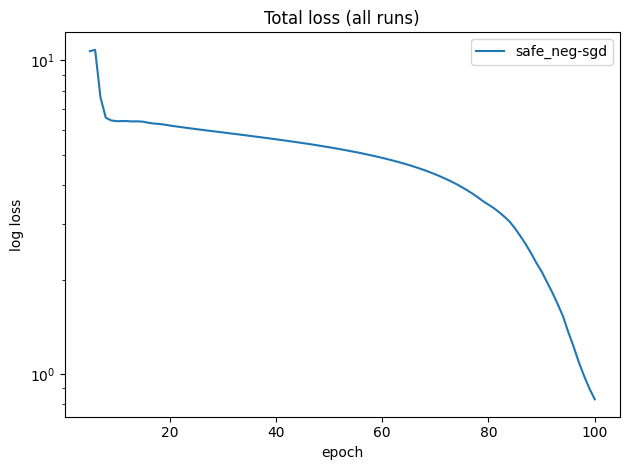

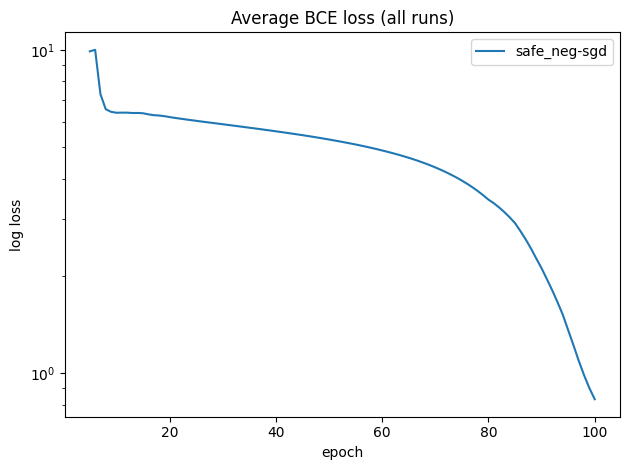

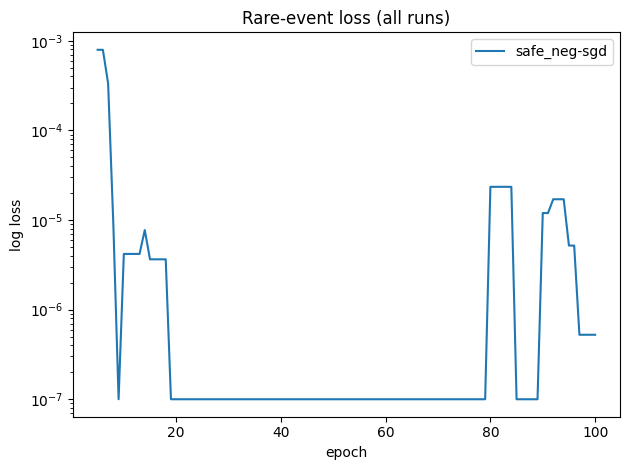

In [ ]:
plot_all_loss(results, show_log=True)

## Accuracies

In [29]:
for config in configs:
    print(f"Evaluating config: {config}")
    _ = eval_one(
        results[config][0], X_test, y_test,
        sigma=SIGMA, SAMPLES_EVAL=SAMPLES_EVAL,
        J_chunk=5000,        # <= keep m small
        N_chunk=512,      # <= keep B small
        B=300             # <= lighter bootstrap
    )
    print("-------------------------------------")

Evaluating config: ('naive', 'sgd')
Accuracy: 72.79%  (CI 95%: [71.54%, 74.00%])
Robust Accuracy: 72.82872%  (CI 95%: [71.73946%, 74.15862%])
Conditional Robust Accuracy: 99.80562%  (CI 95%: [99.72443%, 99.87925%])
-------------------------------------
